In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,lifelines

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


cs224 
last updated: 2020-03-12 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
xarray 0.11.3
scipy 1.2.1
pandas 0.24.2
sklearn 0.20.3
matplotlib 3.0.3
seaborn 0.9.0
pymc3 3.8
lifelines 0.24.1


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 41
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
fname = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
time_series_19_covid_confirmed = pd.read_csv(fname)
fname = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
time_series_19_covid_recovered = pd.read_csv(fname)
fname = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
time_series_19_covid_death = pd.read_csv(fname)

In [5]:
time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149


In [6]:
columns = time_series_19_covid_confirmed.columns[4:]
dcolumns = [pd.to_datetime(dt) for dt in columns]
columns[:3],dcolumns[-3:]

(Index(['1/22/20', '1/23/20', '1/24/20'], dtype='object'),
 [Timestamp('2020-03-09 00:00:00'),
  Timestamp('2020-03-10 00:00:00'),
  Timestamp('2020-03-11 00:00:00')])

In [7]:
# ldf_confirmed = time_series_19_covid_confirmed[columns][time_series_19_covid_confirmed['Country/Region'].isin(['US'])]
# pd.DataFrame(ldf_confirmed.sum(axis=0), columns=['sum']).T

In [8]:
def get_cases_by_selector(selector):
    ldf_confirmed = time_series_19_covid_confirmed[columns][selector]
    ldf_recovered = time_series_19_covid_recovered[columns][selector]
    ldf_death     = time_series_19_covid_death[columns][selector]
    
    if(len(ldf_confirmed) > 1):
        ldf_confirmed = pd.DataFrame(ldf_confirmed.sum(axis=0), columns=['sum']).T
        ldf_recovered = pd.DataFrame(ldf_recovered.sum(axis=0), columns=['sum']).T
        ldf_death     = pd.DataFrame(ldf_death.sum(axis=0), columns=['sum']).T
    
    ldf              = pd.DataFrame(index=dcolumns)
    ldf['confirmed'] = ldf_confirmed.T.values
    ldf['recovered'] = ldf_recovered.T.values
    ldf['death']     = ldf_death.T.values
    
    lv = ldf['confirmed'].iloc[1:].values - ldf['confirmed'].iloc[:-1].values
    ldf['new_confirmed'] = np.concatenate([np.array([0]),lv])

    lv = ldf['recovered'].iloc[1:].values - ldf['recovered'].iloc[:-1].values
    ldf['new_recovered'] = np.concatenate([np.array([0]),lv])

    lv = ldf['death'].iloc[1:].values - ldf['death'].iloc[:-1].values
    ldf['new_death'] = np.concatenate([np.array([0]),lv])
    
    return ldf

def get_cases_by_region(region='Germany'):
    if isinstance(region, str):
        region=[region]
    return get_cases_by_selector(time_series_19_covid_confirmed['Country/Region'].isin(region))

In [9]:
def prepend_fill(in_df, abs_column_name, delta_column_name, first_count, original_df):
    l = len(in_df) + 1
    daily_prepend_count = int(first_count // l)
    daily_prepend_count_fraction = first_count / l - daily_prepend_count
    prepend_count_fraction = 0.0
    for i in range(len(in_df)):
        in_df[delta_column_name].iloc[i] = daily_prepend_count
        delta = int(prepend_count_fraction // 1)
        if delta > 1.0:
            in_df[delta_column_name].iloc[i] += delta
            prepend_count_fraction           -= delta
        prepend_count_fraction += daily_prepend_count_fraction       
    
    in_df[abs_column_name] = in_df[delta_column_name].cumsum()
    
    last_value = in_df[abs_column_name].iloc[-1]
    original_df[delta_column_name].iloc[0] = first_count - last_value
    

def prepend(in_df, first_date=None, init_add=0, mult=1.0):
    if first_date is None:
        first_date = in_df.index[0]
    in_df = in_df.loc[first_date:].copy()
    
    in_df.loc[:,'confirmed'] = (in_df['confirmed'] + init_add) * mult
    in_df['confirmed'] = in_df['confirmed'].astype(np.int)
    
    in_df.loc[:,'new_confirmed'].iloc[0] = in_df['confirmed'].iloc[0]
    in_df.loc[:,'new_confirmed'].iloc[1:] = in_df['confirmed'].iloc[1:].values - in_df['confirmed'].iloc[:-1].values
    # in_df['new_confirmed'] = in_df['new_confirmed'].astype(np.int)
    
    
    prepend_period_in_days = 11
    date_range_1_start = first_date + datetime.timedelta(days=-prepend_period_in_days)
    date_range_1_end   = first_date + datetime.timedelta(days=-1)
    # print(date_range_1_start, date_range_1_end)
    date_range_2_start = first_date + datetime.timedelta(days=-(2*prepend_period_in_days))
    date_range_2_end   = first_date + datetime.timedelta(days=-prepend_period_in_days-1)
    # print(date_range_2_start, date_range_2_end)
    
    prepend_dates = pd.date_range(start=date_range_1_start, end=date_range_1_end, freq='D')    
    prepend_df = pd.DataFrame(np.zeros((len(prepend_dates),len(in_df.columns)), dtype='int'),index=prepend_dates,columns=in_df.columns)
    for name in ['confirmed', 'recovered', 'death']:
        first_confirmed_count = in_df[name].iloc[0]
        last_value = prepend_fill(prepend_df, name, 'new_' + name, first_confirmed_count, in_df)

    in_df = pd.concat([prepend_df, in_df])
    prepend_dates = pd.date_range(start=date_range_2_start, end=date_range_2_end, freq='D')
    prepend_df = pd.DataFrame(np.zeros((len(prepend_dates),len(in_df.columns)), dtype='int'),index=prepend_dates,columns=in_df.columns)
    for name in ['confirmed', 'recovered', 'death']:
        first_confirmed_count = in_df[name].iloc[0]
        last_value = prepend_fill(prepend_df, name, 'new_' + name, first_confirmed_count, in_df)
        
    return pd.concat([prepend_df, in_df])

In [10]:
# # ldf = get_cases_by_region(region='Italy').loc[pd.to_datetime('2020-02-21'):].copy()
# # ldf.loc[:,'confirmed'] = (ldf['confirmed'] + 100)*2.0
# # ldf.loc[:,'new_confirmed'].iloc[0] = ldf['confirmed'].iloc[0]
# # ldf.loc[:,'new_confirmed'].iloc[1:] = ldf['confirmed'].iloc[1:].values - ldf['confirmed'].iloc[:-1].values
# ldf = get_cases_by_region(region='Italy')
# # ldf = prepend(ldf, first_date=pd.to_datetime('2020-02-21'), init_add=100, mult=1.5)
# ldf = prepend(ldf, first_date=pd.to_datetime('2020-02-21'))
# ldf

In [11]:
# ldf = get_cases_by_region(region='Mainland China')
# # ldf = prepend(ldf, first_date=pd.to_datetime('2020-02-21'), init_add=100, mult=1.5)
# ldf = prepend(ldf)
# ldf

In [12]:
def distribute_across_cases_linear(in_df, dt, new_death, timeline_days=3*7):
    three_weeks_ago = dt + datetime.timedelta(days=-timeline_days)
    ldf = in_df[in_df.start_date >= three_weeks_ago]
    already_deaths = ldf.observed_death.sum()
    ldf = ldf.loc[ldf.observed_death == False,:]
    available_death_slots = len(ldf)
    if available_death_slots < new_death:
        raise Exception('available_death_slots < new_death')
    death_indices = np.random.choice(len(ldf), new_death, replace=False)
    death_indices = ldf.index[death_indices]
    
    ldf = in_df[in_df.start_date >= three_weeks_ago]
    added_death = (ldf.observed_death == True).sum() - already_deaths
    # print(new_death, added_death, already_deaths)
    
    return death_indices

* [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

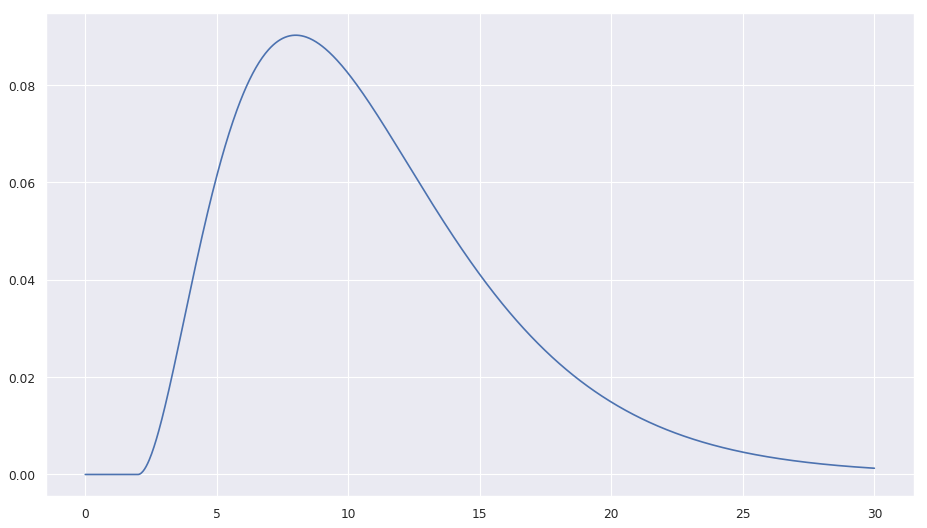

In [13]:
x = np.linspace(0.0,30.0,1000)
gamma_loc   = 2.0
gamma_k     = 3.0
gamme_theta = 3.0
y = stats.gamma(gamma_k, loc=gamma_loc, scale=gamme_theta).pdf(x)
fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(x,y)

In [14]:
def distribute_across_cases_gamma(in_df, dt, new_death, timeline_days=4*7):
    three_weeks_ago = dt + datetime.timedelta(days=-timeline_days)
    ldf = in_df[in_df.start_date >= three_weeks_ago]
    already_deaths = ldf.observed_death.sum()
    ldf = ldf.loc[ldf.observed_death == False,:]
    available_death_slots = len(ldf)
    if available_death_slots < new_death:
        raise Exception('available_death_slots < new_death')
    
    ds_age = (dt - ldf.start_date).dt.days
    distribution = stats.gamma(gamma_k, loc=gamma_loc, scale=gamme_theta).pdf(ds_age)
    distribution = distribution / distribution.sum()
        
    death_indices = np.random.choice(len(ldf), new_death, replace=False, p=distribution)
    death_indices = ldf.index[death_indices]
    
    ldf = in_df[in_df.start_date >= three_weeks_ago]
    added_death = (ldf.observed_death == True).sum() - already_deaths
    # print(new_death, added_death, already_deaths)
    
    return death_indices

In [15]:
def generate_life_lines(in_df, random_seed=None):
    if random_seed is None:
        random_seed = 42 # np.random.RandomState(42)
    np.random.seed(random_seed)
    rdf = pd.DataFrame(columns=['start_date', 'end_date', 'observed_death'])
    end_date = in_df.index[-1] + datetime.timedelta(days=1)
    l = len(in_df)
    for i in range(l):
        dt = in_df.index[i]
        # end existing life-lines
        new_death = in_df['new_death'].iloc[i]
        if new_death > 0:
            # death_indices = distribute_across_cases_linear(rdf, dt, new_death, timeline_days=3*7)
            death_indices = distribute_across_cases_gamma(rdf, dt, new_death, timeline_days=3*7)
            rdf.loc[death_indices, 'observed_death'] = True
            rdf.loc[death_indices, 'end_date']       = dt            
        
        # create new life-lines
        new_lifelines = in_df['new_confirmed'].iloc[i]
        line = [[dt, end_date, False]]
        ldf = pd.DataFrame(line * new_lifelines, columns=['start_date', 'end_date', 'observed_death'])
        rdf = pd.concat([rdf, ldf])
        rdf.reset_index(drop=True, inplace=True)
    
    rdf['day_count'] = (rdf.end_date - rdf.start_date).dt.days
        
    return rdf

In [16]:
import lifelines

In [17]:
class MortalityAnalysis():
    def __init__(self, region, first_date=None, init_add=0, mult=1.0):
        self.region                  = region
        self.first_date              = first_date
        self.init_add                = init_add
        self.mult                    = mult
        self.df                      = get_cases_by_region(region=region)
        self.prepend_df              = prepend(self.df, first_date=first_date, init_add=init_add, mult=mult)
        self.df_lifelines_individual = generate_life_lines(self.prepend_df)
        
#         observed_death_by_day = self.df_lifelines_individual[['end_date', 'observed_death']].groupby(['end_date']).sum()
#         observed_death_by_day['observed_death'] = observed_death_by_day['observed_death'].astype(np.int)
#         self.observed_death_by_day = observed_death_by_day
        
#         ldf = self.prepend_df.new_death - self.observed_death_by_day.observed_death
#         if len(ldf[ldf > 0.0]) > 0:
#             raise Exception('MortalityAnalysis: the death in df_lifelines_individual do not match the ones in prepend_df')
        
    def fit(self):
        kmf_ = lifelines.KaplanMeierFitter()
        kmf_.fit(self.df_lifelines_individual.day_count, self.df_lifelines_individual.observed_death, label='kmf_')
        self.kmf = kmf_

        wbf_ = lifelines.WeibullFitter()
        wbf_.fit(self.df_lifelines_individual.day_count, self.df_lifelines_individual.observed_death, label='wbf_')
        self.wbf = wbf_

        exf_ = lifelines.ExponentialFitter()
        exf_.fit(self.df_lifelines_individual.day_count, self.df_lifelines_individual.observed_death, label='exf_')        
        self.exf = exf_
        
    def plot(self):
        sns.set_style("whitegrid")
        fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
        ax = plt.subplot(111)
        ax.set_ylim([0.0,1.0])

        self.kmf.plot(ax=ax)
        # self.wbf.plot_survival_function(ax=ax)
        # self.exf.plot_survival_function(ax=ax)
        
    def death_rate(self):
        mean  = np.round(float(1-self.kmf.survival_function_.iloc[-1].values)*100,2) 
        lower = np.round(float(1-self.kmf.confidence_interval_.iloc[-1,1])*100,2) 
        upper = np.round(float(1-self.kmf.confidence_interval_.iloc[-1,0])*100,2) 
        return (mean,lower,upper)

In [18]:
china_mortality_analysis = MortalityAnalysis('China')

In [19]:
# china_mortality_analysis.df.tail()

In [20]:
# china_mortality_analysis.df_lifelines_individual.observed_death.sum()

In [21]:
# china_mortality_analysis.df.head()

In [22]:
# china_mortality_analysis.df.tail()

In [23]:
china_mortality_analysis.fit()

In [24]:
# china_mortality_analysis.wbf.print_summary()

# expected_life_time = china_mortality_analysis.wbf.lambda_ * scipy.special.gamma(1 + 1 / china_mortality_analysis.wbf.rho_)
# expected_life_time/365

In [25]:
china_mortality_analysis.death_rate()

(3.96, 3.83, 4.1)

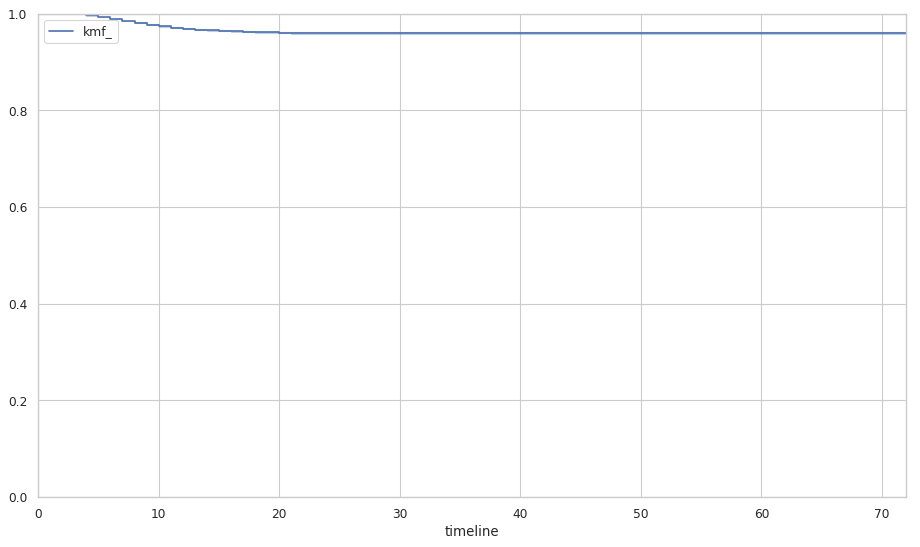

In [26]:
china_mortality_analysis.plot()

(0.42, 0.13, 1.39)


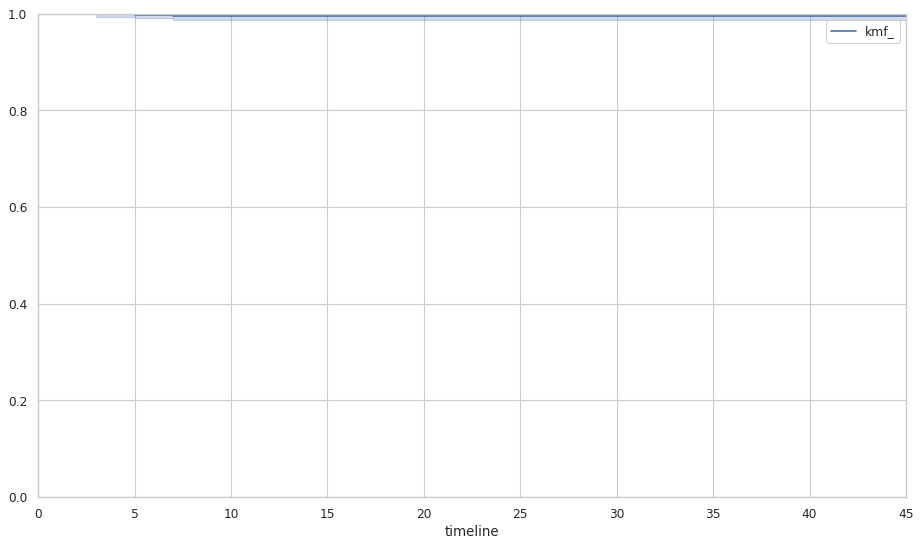

In [27]:
germany_mortality_analysis = MortalityAnalysis('Germany')
germany_mortality_analysis.fit()
print(germany_mortality_analysis.death_rate())
germany_mortality_analysis.plot()

(1.45, 1.02, 2.05)
(1.18, 0.89, 1.57)
8655


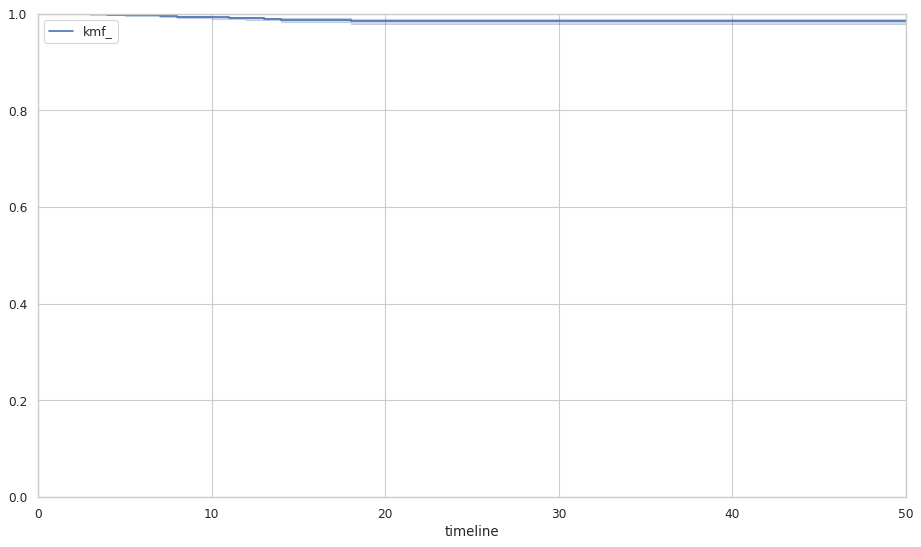

In [28]:
south_korea_name = 'Korea, South'
south_korea_mortality_analysis = MortalityAnalysis(south_korea_name)
south_korea_mortality_analysis.fit()
south_korea_mortality_analysis2 = MortalityAnalysis(south_korea_name, first_date=pd.to_datetime('2020-02-20'), init_add=900)
south_korea_mortality_analysis2.fit()
print(south_korea_mortality_analysis.death_rate())
print(south_korea_mortality_analysis2.death_rate())
print(south_korea_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
south_korea_mortality_analysis.plot()

In [29]:
# south_korea_mortality_analysis.df

In [30]:
# south_korea_mortality_analysis.prepend_df

(13.52, 9.5, 19.05)
(2.62, 1.94, 3.54)
5568


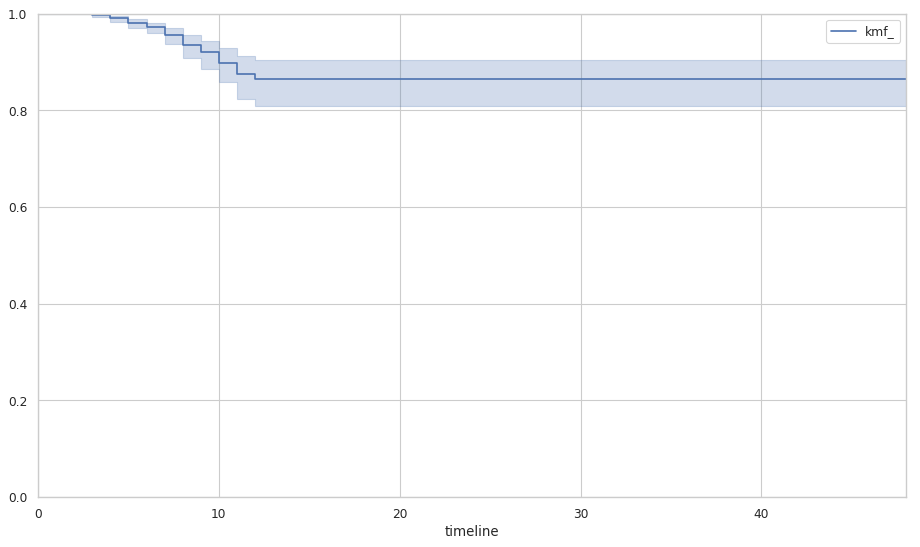

In [31]:
france_mortality_analysis = MortalityAnalysis('France')
france_mortality_analysis.fit()
france_mortality_analysis2 = MortalityAnalysis('France', first_date=pd.to_datetime('2020-02-15'), init_add=500, mult=2.0)
france_mortality_analysis2.fit()
print(france_mortality_analysis.death_rate())
print(france_mortality_analysis2.death_rate())
print(france_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
france_mortality_analysis.plot()

(21.29, 15.06, 29.62)
(3.55, 2.65, 4.74)
8031


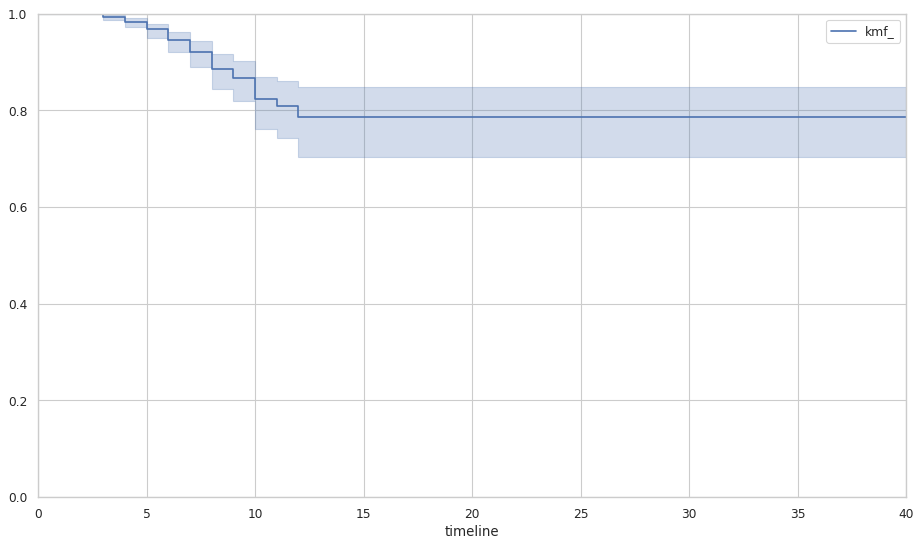

In [32]:
spain_mortality_analysis = MortalityAnalysis('Spain')
spain_mortality_analysis.fit()
spain_mortality_analysis2 = MortalityAnalysis('Spain', first_date=pd.to_datetime('2020-03-03'), init_add=400, mult=3.0)
spain_mortality_analysis2.fit()
print(spain_mortality_analysis.death_rate())
print(spain_mortality_analysis2.death_rate())
print(spain_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
spain_mortality_analysis.plot()

(7.42, 2.89, 18.32)
(1.22, 0.57, 2.63)
1259


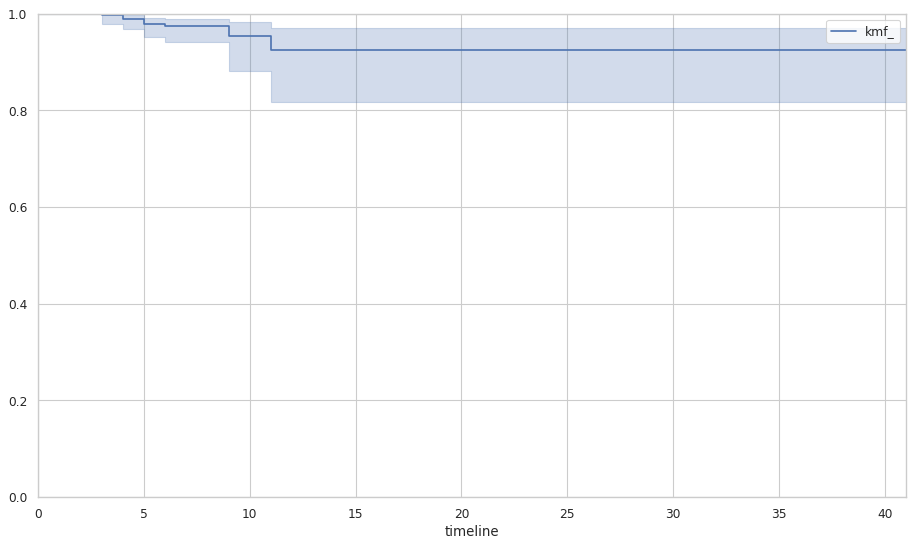

In [33]:
uk_name = 'United Kingdom'
uk_mortality_analysis = MortalityAnalysis(uk_name)
uk_mortality_analysis.fit()
uk_mortality_analysis2 = MortalityAnalysis(uk_name, first_date=pd.to_datetime('2020-03-05'), init_add=800, mult=1.0)
uk_mortality_analysis2.fit()
print(uk_mortality_analysis.death_rate())
print(uk_mortality_analysis2.death_rate())
print(uk_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
uk_mortality_analysis.plot()

In [34]:
# us_mortality_analysis = MortalityAnalysis('US')
# us_mortality_analysis.fit()
# us_mortality_analysis2 = MortalityAnalysis('US', first_date=pd.to_datetime('2020-02-29'), init_add=450, mult=3.0)
# us_mortality_analysis2.fit()
# print(us_mortality_analysis.death_rate())
# print(us_mortality_analysis2.death_rate())
# print(us_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
# us_mortality_analysis.plot()

(27.9, 25.53, 30.44)
(3.54, 3.28, 3.81)
72310


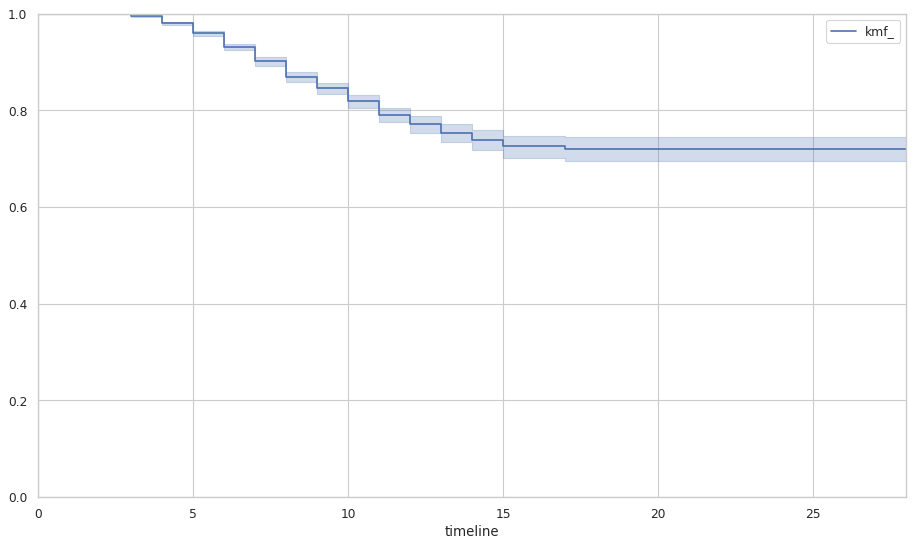

In [35]:
italy_mortality_analysis = MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'))
italy_mortality_analysis.fit()
print(italy_mortality_analysis.death_rate())
italy_mortality_analysis2 = MortalityAnalysis('Italy', first_date=pd.to_datetime('2020-02-21'), init_add=2000, mult=5.0)
italy_mortality_analysis2.fit()
print(italy_mortality_analysis2.death_rate())
print(italy_mortality_analysis2.prepend_df['confirmed'].iloc[-1])
italy_mortality_analysis.plot()

In [36]:
# italy_mortality_analysis2.prepend_df

In [37]:
import rpy2
print(rpy2.__version__)

2.9.4


In [38]:
from rpy2.rinterface import R_VERSION_BUILD
print(R_VERSION_BUILD)

('3', '5.1', '', 74947)


In [39]:
import IPython.display
import rpy2, rpy2.robjects, rpy2.robjects.pandas2ri, rpy2.rinterface, rpy2.robjects.packages, rpy2.interactive, rpy2.robjects.lib.ggplot2, rpy2.robjects.lib.grdevices
rpy2.robjects.pandas2ri.activate()

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('LexisPlotR',)

# R vector of strings
from rpy2.robjects.vectors import StrVector

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:67: UserWarning: This was designed againt ggplot2 version 2.2.1 but you have 3.0.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


In [40]:
grdevices = rpy2.robjects.packages.importr('grDevices')
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

lexis = importr('LexisPlotR')
lexis

rpy2.robjects.packages.Package as a <module 'LexisPlotR'>

In [41]:
lexis_grid = rpy2.robjects.r['lexis.grid']
lexis_lifeline = rpy2.robjects.r['lexis.lifeline']

In [42]:
def plot_lexis(mortality_analysis_instance):
    mylexis = lexis_grid(year_start = 2020, year_end = 2021, age_start = 0, age_end = 1) #  lwd = 0.1

    alpha = 1.0
    ix_present = ~mortality_analysis_instance.df_lifelines_individual.observed_death
    ix_lost    = mortality_analysis_instance.df_lifelines_individual.observed_death
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_present],                                                                               colour = "orange", alpha = alpha, lwd = 0.4)
    mylexis = lexis_lifeline(lg = mylexis , entry = mortality_analysis_instance.df_lifelines_individual['start_date'][ix_lost]   , exit = mortality_analysis_instance.df_lifelines_individual['end_date'][ix_lost], colour = "blue"  , alpha = alpha, lwd = 0.4, lineends = True)

    with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=1.5*1024, height=1.5*896, res=90) as img:
        rpy2.robjects.r.print(mylexis)   
    IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

In [43]:
# plot_lexis(italy_mortality_analysis)

In [44]:
# plot_lexis(italy_mortality_analysis2)

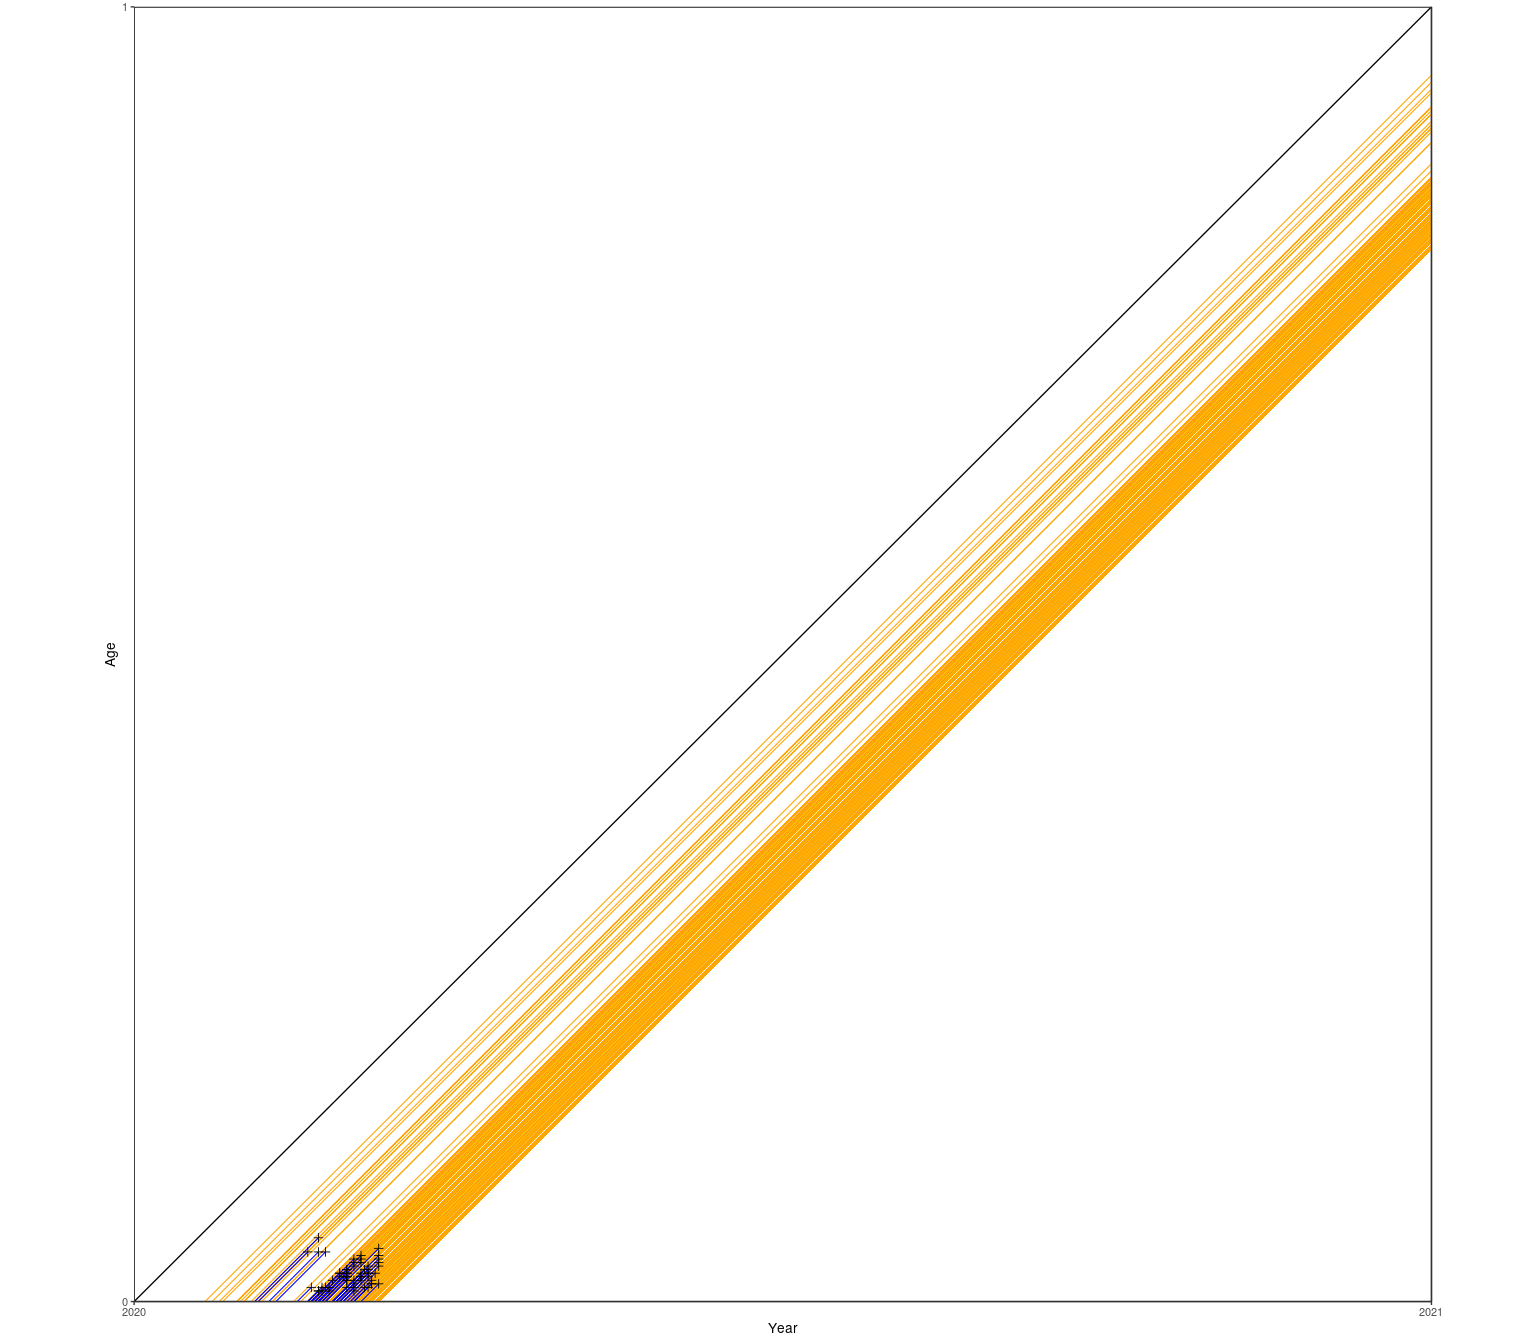

In [45]:
plot_lexis(south_korea_mortality_analysis)